# Proyecto Dataset Diabético

## 📊 Resumen del Dataset

- **Dimensiones**: 101,766 registros × 50 columnas
- **Variable objetivo**: `readmitted` (NO, <30 días, >30 días)
- **Tipo de problema**: Clasificación multiclase (puede convertirse a binaria)

---


In [51]:
import pandas as pd
import numpy as np
import warnings
from sklearn.impute import SimpleImputer
warnings.filterwarnings('ignore')

### Introducción y carga de datos
_Aquí daremos una breve descripción del problema, marcaremos ,los objetivos del proyecto y se hará la carga del dataset y la inspección inicial._

In [52]:
df = pd.read_csv("data/diabetic_data.csv")
    
print(f"\n✓ Dataset cargado exitosamente")
print(f"  Dimensiones originales: {df.shape[0]} filas × {df.shape[1]} columnas")


✓ Dataset cargado exitosamente
  Dimensiones originales: 101766 filas × 50 columnas


### Inspección Inicial del Dataset

In [53]:
# Información general del dataset
print("=" * 80)
print("INFORMACIÓN GENERAL DEL DATASET")
print("=" * 80)
df.info()

INFORMACIÓN GENERAL DEL DATASET
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            1

In [54]:
# Primeras filas del dataset
print("\n" + "=" * 80)
print("PRIMERAS 5 FILAS DEL DATASET")
print("=" * 80)
display(df.head())


PRIMERAS 5 FILAS DEL DATASET


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [55]:
# Estadísticas descriptivas
print("\n" + "=" * 80)
print("ESTADÍSTICAS DESCRIPTIVAS")
print("=" * 80)
display(df.describe())


ESTADÍSTICAS DESCRIPTIVAS


,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.026403e+08,3.869636e+07,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.496119e+07,2.341322e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523890e+08,4.550514e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302709e+08,8.754595e+07,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


## Limpieza y Preprocesamiento de Datos

### Análisis de valores faltantes

In [56]:
# Análisis de valores faltantes
print("\n" + "=" * 80)
print("ANÁLISIS DE VALORES FALTANTES")
print("=" * 80)

# Valores '?' que se consideran como faltantes
missing_counts = (df == '?').sum()
missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False)

if len(missing_counts) > 0:
    print("\nColumnas con '?' (valores faltantes):")
    for col, count in missing_counts.items():
        pct = (count / len(df)) * 100
        print(f"  {col:30s}: {count:6d} ({pct:5.2f}%)")
else:
    print("No hay valores '?' en el dataset")

# Valores NaN tradicionales
nan_counts = df.isnull().sum()
nan_counts = nan_counts[nan_counts > 0].sort_values(ascending=False)

if len(nan_counts) > 0:
    print("\nColumnas con NaN:")
    for col, count in nan_counts.items():
        pct = (count / len(df)) * 100
        print(f"  {col:30s}: {count:6d} ({pct:5.2f}%)")
else:
    print("\nNo hay valores NaN en el dataset")


ANÁLISIS DE VALORES FALTANTES

Columnas con '?' (valores faltantes):
  weight                        :  98569 (96.86%)
  medical_specialty             :  49949 (49.08%)
  payer_code                    :  40256 (39.56%)
  race                          :   2273 ( 2.23%)
  diag_3                        :   1423 ( 1.40%)
  diag_2                        :    358 ( 0.35%)
  diag_1                        :     21 ( 0.02%)

Columnas con NaN:
  max_glu_serum                 :  96420 (94.75%)
  A1Cresult                     :  84748 (83.28%)


### Análisis de duplicados

In [57]:
# Análisis de duplicados
print("\n" + "=" * 80)
print("ANÁLISIS DE DUPLICADOS")
print("=" * 80)

# Duplicados por encounter_id (cada encuentro debe ser único)
duplicate_encounters = df['encounter_id'].duplicated().sum()
print(f"Registros duplicados por encounter_id: {duplicate_encounters}")

# Duplicados por patient_nbr (un paciente puede tener múltiples encuentros)
unique_patients = df['patient_nbr'].nunique()
total_encounters = len(df)
print(f"Pacientes únicos: {unique_patients}")
print(f"Total de encuentros: {total_encounters}")
print(f"Promedio de encuentros por paciente: {total_encounters / unique_patients:.2f}")


ANÁLISIS DE DUPLICADOS
Registros duplicados por encounter_id: 0
Pacientes únicos: 71518
Total de encuentros: 101766
Promedio de encuentros por paciente: 1.42


### ~~Demostración de Operaciones Vectorizadas con NumPy~~ (Creo que esto sobra un poco)

In [ ]:
""" import time

# Convertir columna numérica a array de NumPy
time_in_hospital = df['time_in_hospital'].values

print("=" * 80)
print("COMPARACIÓN: OPERACIONES VECTORIZADAS vs LOOPS TRADICIONALES")
print("=" * 80)

# Operación 1: Calcular suma usando loop tradicional
start_time = time.time()
total_loop = 0
for value in time_in_hospital:
    total_loop += value
time_loop = time.time() - start_time

# Operación 1: Calcular suma usando NumPy (vectorizado)
start_time = time.time()
total_numpy = np.sum(time_in_hospital)
time_numpy = time.time() - start_time

print(f"\n1. SUMA DE VALORES:")
print(f"   Loop tradicional: {total_loop:.2f} - Tiempo: {time_loop*1000:.4f} ms")
print(f"   NumPy vectorizado: {total_numpy:.2f} - Tiempo: {time_numpy*1000:.4f} ms")
if time_numpy > 0:
    print(f"   Speedup: {time_loop/time_numpy:.1f}x más rápido")
else:
    print(f"   Speedup: NumPy es extremadamente rápido (< 0.01ms)")

# Operación 2: Calcular media usando loop
start_time = time.time()
mean_loop = sum(time_in_hospital) / len(time_in_hospital)
time_loop = time.time() - start_time

# Operación 2: Calcular media usando NumPy
start_time = time.time()
mean_numpy = np.mean(time_in_hospital)
time_numpy = time.time() - start_time

print(f"\n2. MEDIA:")
print(f"   Loop tradicional: {mean_loop:.2f} - Tiempo: {time_loop*1000:.4f} ms")
print(f"   NumPy vectorizado: {mean_numpy:.2f} - Tiempo: {time_numpy*1000:.4f} ms")
if time_numpy > 0:
    print(f"   Speedup: {time_loop/time_numpy:.1f}x más rápido")
else:
    print(f"   Speedup: NumPy es extremadamente rápido (< 0.01ms)")

# Operación 3: Normalización Min-Max usando loop
start_time = time.time()
min_val = min(time_in_hospital)
max_val = max(time_in_hospital)
normalized_loop = [(x - min_val) / (max_val - min_val) for x in time_in_hospital]
time_loop = time.time() - start_time

# Operación 3: Normalización Min-Max usando NumPy
start_time = time.time()
normalized_numpy = (time_in_hospital - np.min(time_in_hospital)) / (np.max(time_in_hospital) - np.min(time_in_hospital))
time_numpy = time.time() - start_time

print(f"\n3. NORMALIZACIÓN MIN-MAX:")
print(f"   Loop tradicional: Tiempo: {time_loop*1000:.4f} ms")
print(f"   NumPy vectorizado: Tiempo: {time_numpy*1000:.4f} ms")
if time_numpy > 0:
    print(f"   Speedup: {time_loop/time_numpy:.1f}x más rápido")
else:
    print(f"   Speedup: NumPy es extremadamente rápido (< 0.01ms)")

print(f"\n✓ Las operaciones vectorizadas de NumPy son significativamente más rápidas") """

### Eliminación de columnas irrelevantes

**Eliminación de columnas con mayoría de nulos**

Dado que la columna ``weight`` tiene un 97% de nulos, consideramos que la mejor estrategia es eliminarla.

In [58]:
# Drop columna 'weight'
print("\n" + "=" * 80)
print("ANÁLISIS Y ELIMINACIÓN DE 'WEIGHT'")
print("=" * 80)
df = df.drop(columns=['weight'])
print(f"  Dimensiones después de eliminar 'weight': {df.shape[0]} filas × {df.shape[1]} columnas")


ANÁLISIS Y ELIMINACIÓN DE 'WEIGHT'
  Dimensiones después de eliminar 'weight': 101766 filas × 49 columnas


**Eliminación de IDs no informativos: ``encounter_id`` y ``patient_nbr``** <br>
Añadir justificación

In [48]:
# Falta por completar

### Imputación de valores faltantes

**Imputación de ``race`` con la moda** <br>
_falta justificación_

In [59]:
print("\n" + "=" * 80)
print("IMPUTACIÓN DE 'RACE' CON LA MODA")
print("=" * 80)
# Paso 1: Convertir '?' a NaN solo en la columna 'race'
df['race'] = df['race'].replace('?', np.nan)

# Paso 2: Backup y verificación
print("Valores nulos originales en 'race':", df['race'].isna().sum())
df['race_backup'] = df['race'].copy()

# Paso 3: Imputación
race_imputer = SimpleImputer(strategy='most_frequent')
df['race'] = race_imputer.fit_transform(df[['race']]).ravel()

# Paso 4: Identificar valores imputados
imputed_mask = df['race_backup'].isna() & df['race'].notna()
imputed_values = df.loc[imputed_mask, 'race']

print(f"\nSe imputaron {len(imputed_values)} valores:")
print(imputed_values.value_counts())



IMPUTACIÓN DE 'RACE' CON LA MODA
Valores nulos originales en 'race': 2273

Se imputaron 2273 valores:
race
Caucasian    2273
Name: count, dtype: int64


### Sustitución de Valores Faltantes en `payer_code` y `medical_specialty`

Optamos por crear una categoría explícita `"Unknown"` en lugar de eliminar registros o imputar con la moda, ya que la ausencia de información en estas columnas puede ser informativa por sí misma.

La falta de información del pagador (`payer_code`) puede reflejar situaciones como pacientes sin seguro médico o casos de emergencia donde la documentación no fue completada adecuadamente. De manera similar, la ausencia de especialidad médica asignada (`medical_specialty`) puede indicar atención generalista o admisiones de emergencia sin derivación específica.

Ambas columnas presentan una proporción considerable de valores faltantes. Eliminar estos registros comprometería significativamente la capacidad de análisis, mientras que la imputación con moda introduciría sesgo al asumir que todos los valores faltantes pertenecen a la categoría más frecuente.

Al preservar estos registros mediante la categoría `"Unknown"`, mantenemos la integridad del dataset y permitimos que los modelos de machine learning evalúen si la ausencia de esta información administrativa es predictiva de readmisión hospitalaria.

In [60]:
print("=" * 80)
print("ANÁLISIS DE VALORES FALTANTES: payer_code y medical_specialty")
print("=" * 80)

# Calcular porcentajes de valores '?' (que serán reemplazados por 'Unknown')
total_rows = len(df)

payer_missing = (df['payer_code'] == '?').sum()
payer_pct = (payer_missing / total_rows) * 100

specialty_missing = (df['medical_specialty'] == '?').sum()
specialty_pct = (specialty_missing / total_rows) * 100

print(f"\npayer_code:")
print(f"  Valores '?': {payer_missing:,} ({payer_pct:.2f}%)")

print(f"\nmedical_specialty:")
print(f"  Valores '?': {specialty_missing:,} ({specialty_pct:.2f}%)")

print(f"\n✓ Estos valores serán reemplazados por 'Unknown'")

ANÁLISIS DE VALORES FALTANTES: payer_code y medical_specialty

payer_code:
  Valores '?': 40,256 (39.56%)

medical_specialty:
  Valores '?': 49,949 (49.08%)

✓ Estos valores serán reemplazados por 'Unknown'


In [61]:
# Sustituir '?' por 'Unknown' en payer_code y medical_specialty
df['payer_code'] = df['payer_code'].replace('?', 'Unknown')
df['medical_specialty'] = df['medical_specialty'].replace('?', 'Unknown')

print(f"✓ Valores '?' reemplazados por 'Unknown' en payer_code y medical_specialty")
print(f"  payer_code: {(df['payer_code'] == 'Unknown').sum()} valores 'Unknown'")
print(f"  medical_specialty: {(df['medical_specialty'] == 'Unknown').sum()} valores 'Unknown'")

✓ Valores '?' reemplazados por 'Unknown' en payer_code y medical_specialty
  payer_code: 40256 valores 'Unknown'
  medical_specialty: 49949 valores 'Unknown'


### Transformación de Variable Objetivo
El dataset original contiene la variable `readmitted` con tres categorías:
- `NO`: El paciente no fue readmitido
- `>30`: El paciente fue readmitido después de 30 días
- `<30`: El paciente fue readmitido en menos de 30 días

Nuestro objetivo es **predecir readmisiones tempranas** (en menos de 30 días), ya que estas representan:

1. **Mayor costo para el sistema de salud:** Las readmisiones tempranas suelen estar relacionadas con complicaciones evitables o alta prematura. En EEUU, donde se recopiló la información, Medicare suele penalizar a los hospitales cuyos pacientes son ingresados de nuevo en un período de 30 días o menos.

2. **Indicador de calidad asistencial:** Una readmisión en <30 días puede señalar deficiencias en el plan de alta, seguimiento inadecuado o falta de educación al paciente.

3. **Oportunidad de intervención:** Identificar pacientes en riesgo de readmisión temprana permite implementar programas de seguimiento intensivo post-alta.
<br><br>


**Decisión de Modelado** <br>
Transformaremos el problema en **clasificación binaria**:
- **Clase positiva (1):** Readmisión en <30 días
- **Clase negativa (0):** No readmisión o readmisión >30 días

Esta decisión implica que tratamos las readmisiones tardías (>30 días) como "no problemáticas" desde la perspectiva de calidad asistencial inmediata, enfocándonos en prevenir las readmisiones que ocurren poco después del alta hospitalaria.

ANÁLISIS DE LA VARIABLE OBJETIVO ORIGINAL

Aviso: la columna 'readmitted' no está presente. Se recrea una versión aproximada a partir de 'readmitted_binary'.

Distribución (reconstruida) de 'readmitted':
readmitted_binary
NO/>30    90409
<30       11357
Name: count, dtype: int64

Proporción:
readmitted_binary
NO/>30    88.84
<30       11.16
Name: proportion, dtype: float64

VARIABLE OBJETIVO TRANSFORMADA

Distribución de 'readmitted_binary':
  0 (Sin readmisión <30 días): 90,409 (88.84%)
  1 (Readmitido <30 días):      11,357 (11.16%)

  Ratio de desbalanceo: 7.96:1
    → Dataset desbalanceado. Considerar técnicas de balanceo (SMOTE, class_weight, etc.)

✓ Columna 'readmitted' eliminada (si existía) para evitar data leakage
✓ Variable objetivo: 'readmitted_binary' (0 = No/<30, 1 = <30)


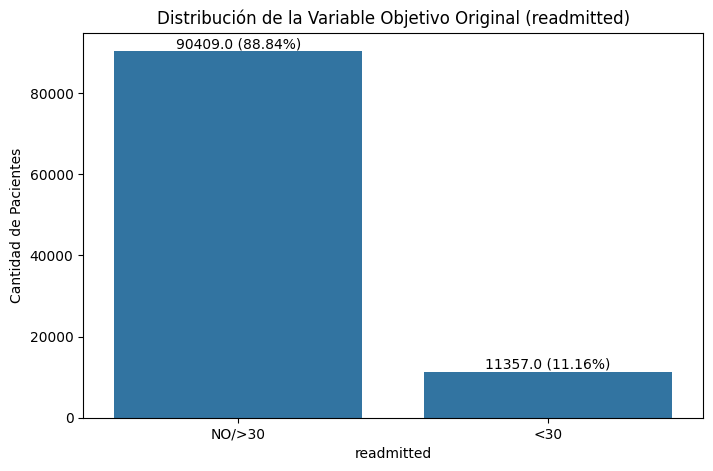

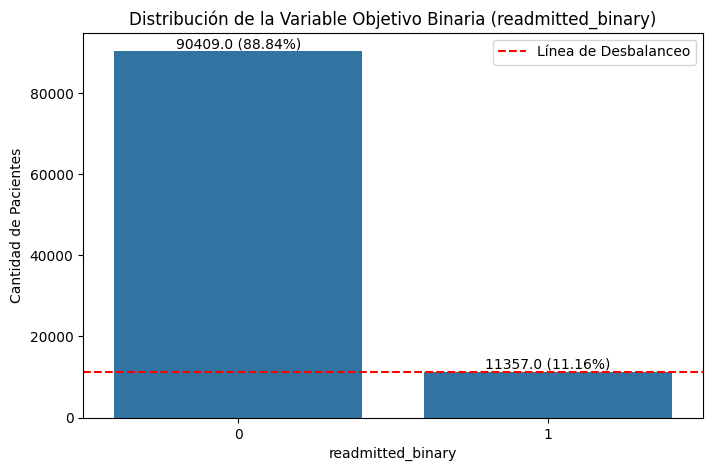

In [66]:
print("=" * 80)
print("ANÁLISIS DE LA VARIABLE OBJETIVO ORIGINAL")
print("=" * 80)

# Intentar recuperar la columna original 'readmitted'. Si no existe, reconstruir a partir de 'readmitted_binary'
if 'readmitted' in df.columns:
    original_readmitted = df['readmitted'].copy()
    print("\nDistribución de 'readmitted' (original):")
    print(original_readmitted.value_counts())
    print("\nProporción:")
    print(original_readmitted.value_counts(normalize=True).mul(100).round(2))
else:
    # Si 'readmitted' no existe, recreamos una versión aproximada a partir de 'readmitted_binary'
    if 'readmitted_binary' in df.columns:
        print("\nAviso: la columna 'readmitted' no está presente. Se recrea una versión aproximada a partir de 'readmitted_binary'.")
        original_readmitted = df['readmitted_binary'].map({1: '<30', 0: 'NO/>30'})
        print("\nDistribución (reconstruida) de 'readmitted':")
        print(original_readmitted.value_counts())
        print("\nProporción:")
        print(original_readmitted.value_counts(normalize=True).mul(100).round(2))
    else:
        # Último recurso: crear una serie 'Unknown'
        print("\nAviso: ni 'readmitted' ni 'readmitted_binary' están presentes. Se crea una serie 'Unknown' para visualización.")
        original_readmitted = pd.Series(['Unknown'] * len(df), index=df.index)
        print(original_readmitted.value_counts())

# Asegurar que exista la variable binaria 'readmitted_binary'
if 'readmitted_binary' not in df.columns:
    df['readmitted_binary'] = (original_readmitted == '<30').astype(int)

print("\n" + "=" * 80)
print("VARIABLE OBJETIVO TRANSFORMADA")
print("=" * 80)

# Distribución de la variable binaria (se asume que existe ahora)
readmit_counts = df['readmitted_binary'].value_counts().sort_index()
cnt0 = int(readmit_counts.get(0, 0))
cnt1 = int(readmit_counts.get(1, 0))

print("\nDistribución de 'readmitted_binary':")
print(f"  0 (Sin readmisión <30 días): {cnt0:,} ({(cnt0/len(df)*100) if len(df)>0 else 0:.2f}%)")
print(f"  1 (Readmitido <30 días):      {cnt1:,} ({(cnt1/len(df)*100) if len(df)>0 else 0:.2f}%)")

# Calcular desbalanceo de clases (proteger división por cero)
if cnt1 == 0:
    print("\n  No hay casos positivos (1). No se puede calcular ratio de desbalanceo.")
    imbalance_ratio = float('inf')
else:
    imbalance_ratio = cnt0 / cnt1
    print(f"\n  Ratio de desbalanceo: {imbalance_ratio:.2f}:1")

if cnt1 == 0:
    print(f"    → No hay positivos. Revisar la creación de la variable objetivo.")
else:
    if imbalance_ratio > 3:
        print(f"    → Dataset desbalanceado. Considerar técnicas de balanceo (SMOTE, class_weight, etc.)")
    else:
        print(f"    → Desbalanceo moderado. Monitorear métricas como F1-Score y AUC-ROC.")

# Eliminar la columna original si existe para evitar data leakage (no lanzar error si no existe)
df = df.drop(columns=['readmitted'], errors='ignore')
print(f"\n✓ Columna 'readmitted' eliminada (si existía) para evitar data leakage")
print(f"✓ Variable objetivo: 'readmitted_binary' (0 = No/<30, 1 = <30)")

#Agregar visualización de distribución original (usar original_readmitted que siempre existe ahora)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.countplot(x=original_readmitted, order=original_readmitted.value_counts().index)
plt.title('Distribución de la Variable Objetivo Original (readmitted)')
plt.xlabel('readmitted')
plt.ylabel('Cantidad de Pacientes')
total_orig = len(original_readmitted)
for p in plt.gca().patches:
    height = p.get_height()
    plt.gca().annotate(f'{height} ({(height/total_orig)*100:.2f}%)',
                       (p.get_x() + p.get_width() / 2, height),
                       ha='center', va='bottom')
    
#Mostrar gráfica de distribución binaria
plt.figure(figsize=(8,5))
sns.countplot(x='readmitted_binary', data=df, order=df['readmitted_binary'].value_counts().index)
plt.title('Distribución de la Variable Objetivo Binaria (readmitted_binary)')
plt.xlabel('readmitted_binary')
plt.ylabel('Cantidad de Pacientes')
total = len(df)
for p in plt.gca().patches:
    height = p.get_height()
    plt.gca().annotate(f'{height} ({(height/total)*100:.2f}%)',
                       (p.get_x() + p.get_width() / 2, height),
                       ha='center', va='bottom')

# Añadir línea de desbalanceo (sobre la gráfica binaria) solo si hay positivos
if cnt1 > 0:
    plt.axhline(y=cnt1, color='r', linestyle='--', label='Línea de Desbalanceo')
    plt.legend()
plt.show()


### Encoding de Variables Categóricas

In [13]:
# Identificar columnas categóricas y numéricas
print("=" * 80)
print("PREPARACIÓN PARA ENCODING")
print("=" * 80)

# Columnas a excluir del encoding (IDs y columnas ya procesadas)
exclude_cols = ['encounter_id', 'patient_nbr', 'readmitted', 'readmitted_binary', 'early_readmission']

# Identificar columnas categóricas (object type)
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col not in exclude_cols]

print(f"\nColumnas categóricas identificadas ({len(categorical_cols)}):")
for col in categorical_cols:
    unique_count = df[col].nunique()
    print(f"  {col:30s}: {unique_count:3d} valores únicos")

# Separar entre nominales (muchos valores) y binarias/ordinales
high_cardinality_cols = [col for col in categorical_cols if df[col].nunique() > 10]
low_cardinality_cols = [col for col in categorical_cols if df[col].nunique() <= 10]

print(f"\nColumnas de alta cardinalidad (>10 valores): {len(high_cardinality_cols)}")
print(f"Columnas de baja cardinalidad (≤10 valores): {len(low_cardinality_cols)}")

PREPARACIÓN PARA ENCODING

Columnas categóricas identificadas (35):
  race                          :   5 valores únicos
  gender                        :   3 valores únicos
  age                           :  10 valores únicos
  payer_code                    :  18 valores únicos
  medical_specialty             :  73 valores únicos
  diag_1                        : 717 valores únicos
  diag_2                        : 749 valores únicos
  diag_3                        : 790 valores únicos
  max_glu_serum                 :   3 valores únicos
  A1Cresult                     :   3 valores únicos
  metformin                     :   4 valores únicos
  repaglinide                   :   4 valores únicos
  nateglinide                   :   4 valores únicos
  chlorpropamide                :   4 valores únicos
  glimepiride                   :   4 valores únicos
  acetohexamide                 :   2 valores únicos
  glipizide                     :   4 valores únicos
  glyburide                    

In [14]:
# Aplicar Label Encoding a columnas de baja cardinalidad
from sklearn.preprocessing import LabelEncoder

print("\n" + "=" * 80)
print("LABEL ENCODING (para columnas de baja cardinalidad)")
print("=" * 80)

label_encoders = {}
df_encoded = df.copy()

for col in low_cardinality_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
    label_encoders[col] = le
    print(f"✓ {col}: {len(le.classes_)} clases codificadas")

print(f"\n✓ Total de columnas con Label Encoding: {len(low_cardinality_cols)}")


LABEL ENCODING (para columnas de baja cardinalidad)
✓ race: 5 clases codificadas
✓ gender: 3 clases codificadas
✓ age: 10 clases codificadas
✓ max_glu_serum: 4 clases codificadas
✓ A1Cresult: 4 clases codificadas
✓ metformin: 4 clases codificadas
✓ repaglinide: 4 clases codificadas
✓ nateglinide: 4 clases codificadas
✓ chlorpropamide: 4 clases codificadas
✓ glimepiride: 4 clases codificadas
✓ acetohexamide: 2 clases codificadas
✓ glipizide: 4 clases codificadas
✓ glyburide: 4 clases codificadas
✓ tolbutamide: 2 clases codificadas
✓ pioglitazone: 4 clases codificadas
✓ rosiglitazone: 4 clases codificadas
✓ acarbose: 4 clases codificadas
✓ miglitol: 4 clases codificadas
✓ troglitazone: 2 clases codificadas
✓ tolazamide: 3 clases codificadas
✓ examide: 1 clases codificadas
✓ citoglipton: 1 clases codificadas
✓ insulin: 4 clases codificadas
✓ glyburide-metformin: 4 clases codificadas
✓ glipizide-metformin: 2 clases codificadas
✓ glimepiride-pioglitazone: 2 clases codificadas
✓ metformin-r

In [15]:
# Aplicar One-Hot Encoding a columnas de alta cardinalidad
print("\n" + "=" * 80)
print("ONE-HOT ENCODING (para columnas de alta cardinalidad)")
print("=" * 80)

# Para evitar explosión dimensional, limitaremos las columnas de alta cardinalidad
# o usaremos frequency encoding como alternativa

print(f"\nColumnas de alta cardinalidad que se procesarán:")
for col in high_cardinality_cols:
    print(f"  {col}: {df_encoded[col].nunique()} valores únicos")

# Decisión: Para payer_code (18 valores) aplicaremos One-Hot
# Para las demás columnas con demasiados valores (diagnosis codes),
# usaremos Label Encoding ya que One-Hot crearía demasiadas columnas

# Columnas para One-Hot (cardinalidad moderada)
onehot_cols = ['payer_code']  # 18 valores únicos es manejable
onehot_cols = [col for col in onehot_cols if col in high_cardinality_cols]

if onehot_cols:
    df_encoded = pd.get_dummies(df_encoded, columns=onehot_cols, prefix=onehot_cols, drop_first=True)
    print(f"\n✓ One-Hot Encoding aplicado a: {onehot_cols}")
    print(f"  Nuevas columnas creadas: {len([c for c in df_encoded.columns if any(pc in c for pc in onehot_cols)])}")
else:
    print("\n⚠️  No hay columnas seleccionadas para One-Hot Encoding")

# Para las demás columnas de alta cardinalidad, aplicar Label Encoding
remaining_high_card = [col for col in high_cardinality_cols if col not in onehot_cols]
for col in remaining_high_card:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
    label_encoders[col] = le
    print(f"✓ Label Encoding aplicado a {col}")

print(f"\n✓ Encoding completo. Nueva dimensión: {df_encoded.shape}")


ONE-HOT ENCODING (para columnas de alta cardinalidad)

Columnas de alta cardinalidad que se procesarán:
  payer_code: 18 valores únicos
  medical_specialty: 73 valores únicos
  diag_1: 717 valores únicos
  diag_2: 749 valores únicos
  diag_3: 790 valores únicos

✓ One-Hot Encoding aplicado a: ['payer_code']
  Nuevas columnas creadas: 17
✓ Label Encoding aplicado a medical_specialty
✓ Label Encoding aplicado a diag_1
✓ Label Encoding aplicado a diag_2
✓ Label Encoding aplicado a diag_3

✓ Encoding completo. Nueva dimensión: (101766, 67)


### Feature Engineering

In [16]:
# Crear nuevas características combinadas
print("=" * 80)
print("FEATURE ENGINEERING")
print("=" * 80)

# Feature 1: Total de visitas (outpatient + emergency + inpatient)
df_encoded['total_visits'] = (df_encoded['number_outpatient'] + 
                               df_encoded['number_emergency'] + 
                               df_encoded['number_inpatient'])
print(f"✓ Feature creada: total_visits")
print(f"  Rango: [{df_encoded['total_visits'].min()}, {df_encoded['total_visits'].max()}]")
print(f"  Media: {df_encoded['total_visits'].mean():.2f}")

# Feature 2: Cambios en medicación (change + diabetesMed)
# Primero, convertir a numérico si no lo son
if df_encoded['change'].dtype == 'object':
    df_encoded['change'] = df_encoded['change'].map({'No': 0, 'Ch': 1})
if df_encoded['diabetesMed'].dtype == 'object':
    df_encoded['diabetesMed'] = df_encoded['diabetesMed'].map({'No': 0, 'Yes': 1})

df_encoded['medication_changes'] = df_encoded['change'] + df_encoded['diabetesMed']
print(f"\n✓ Feature creada: medication_changes")
print(f"  Rango: [{df_encoded['medication_changes'].min()}, {df_encoded['medication_changes'].max()}]")
print(f"  Distribución:")
print(df_encoded['medication_changes'].value_counts().sort_index())

# Feature 3: Ratio de procedimientos por día hospitalizado
df_encoded['procedures_per_day'] = df_encoded['num_procedures'] / (df_encoded['time_in_hospital'] + 1)  # +1 para evitar división por 0
print(f"\n✓ Feature creada: procedures_per_day")
print(f"  Media: {df_encoded['procedures_per_day'].mean():.2f}")

print(f"\n✓ Feature Engineering completado. Total de features: {df_encoded.shape[1]}")

FEATURE ENGINEERING
✓ Feature creada: total_visits
  Rango: [0, 80]
  Media: 1.20

✓ Feature creada: medication_changes
  Rango: [1, 2]
  Distribución:
medication_changes
1    70414
2    31352
Name: count, dtype: int64

✓ Feature creada: procedures_per_day
  Media: 0.30

✓ Feature Engineering completado. Total de features: 70


### Standard Scaler para variables numéricas

In [17]:
from sklearn.preprocessing import StandardScaler

print("=" * 80)
print("NORMALIZACIÓN DE VARIABLES NUMÉRICAS")
print("=" * 80)

scaler = StandardScaler()

# Identificar columnas numéricas (excluyendo las variables objetivo y IDs)
numerical_cols = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 
                  'num_medications', 'number_outpatient', 'number_emergency', 
                  'number_inpatient', 'number_diagnoses', 'total_visits', 
                  'medication_changes', 'procedures_per_day']

# Verificar que las columnas existen
numerical_cols = [col for col in numerical_cols if col in df_encoded.columns]

print(f"\nColumnas numéricas a normalizar ({len(numerical_cols)}):")
for col in numerical_cols:
    print(f"  - {col}")

# Aplicar StandardScaler
df_encoded[numerical_cols] = scaler.fit_transform(df_encoded[numerical_cols])

print(f"\n✓ Normalización completada")
print(f"  Media después de escalar (debe ser ~0): {df_encoded[numerical_cols].mean().mean():.6f}")
print(f"  Desviación estándar (debe ser ~1): {df_encoded[numerical_cols].std().mean():.6f}")

NORMALIZACIÓN DE VARIABLES NUMÉRICAS

Columnas numéricas a normalizar (11):
  - time_in_hospital
  - num_lab_procedures
  - num_procedures
  - num_medications
  - number_outpatient
  - number_emergency
  - number_inpatient
  - number_diagnoses
  - total_visits
  - medication_changes
  - procedures_per_day

✓ Normalización completada
  Media después de escalar (debe ser ~0): 0.000000
  Desviación estándar (debe ser ~1): 1.000005


### Categorización ICD-9
El ICD-9 (_International Classification of Diseases, 9ª revisión_) es un sistema estandarizado utilizado para **clasificar y codificar enfermedades, síntomas, causas externas y ciertos procedimientos médicos**. Cada diagnóstico se representa mediante un código numérico de 3 a 5 dígitos:
- **Primeros 3 dígitos**: definen la categoría general (tipo de enfermedad o condición).
- **Dígitos adicionales**: aportan mayor especificidad, indicando detalles como localización, tipo, gravedad u otras características.

La estructura del ICD-9 se organiza en **capítulos temáticos**, agrupando las patologías según el sistema afectado (por ejemplo: _enfermedades infecciosas, sistema respiratorio, sistema cardiovascular_, entre otros).

En esta sección nuestro objetivo es transformar **códigos específicos** (250.01 o 428.0, por ejemplo) en **etiquetas interpretables** como _Diabetes, Circulatory, Respiratory_, entre otros. Esto facilita el modelado y análisis estadístico, ya que:

- Reduce la complejidad del análisis
- Mantiene el equilibrio entre granularidad y simplicidad, capturando información clínica relevante.


In [18]:
def categorize_diagnosis_detailed(diag_code):
    """
    Agrupa códigos ICD-9 en categorías principales según capítulos estándar.
    Pensada para códigos de diagnóstico (no de procedimiento).
    """
    try:
        diag = str(diag_code).strip().upper()
        if not diag or diag == '?' or diag == 'NAN':
            return 'Unknown'
        
        if diag.startswith('E'):
            return 'External_Causes'
        if diag.startswith('V'):
            return 'Supplementary'
        
        if '.' in diag:
            code_main = int(diag.split('.')[0])
        else:
            code_main = int(float(diag))
        
        # ===== SUBCATEGORÍAS ESPECÍFICAS =====
        # Diabetes y complicaciones
        if code_main == 250:
            return 'Diabetes'
        
        # Enfermedades cardiovasculares (alta correlación con readmisión)
        if code_main in range(410, 415):  # 410-414: Enfermedad isquémica del corazón
            return 'Circulatory_Ischemic_Heart'
        if code_main in range(428, 429):  # 428: Insuficiencia cardíaca
            return 'Circulatory_Heart_Failure'
        if code_main in range(390, 460):  # Resto de circulatorias
            return 'Circulatory_Other'
        
        # Enfermedades respiratorias (común en hospitalizaciones)
        if code_main in range(480, 488):  # Neumonía
            return 'Respiratory_Pneumonia'
        if code_main in range(490, 493):  # EPOC
            return 'Respiratory_COPD'
        if code_main in range(460, 520):  # Resto
            return 'Respiratory_Other'
        
        # Enfermedades renales (complicación diabética)
        if code_main in range(580, 590):  # Nefritis, nefrosis
            return 'Genitourinary_Renal'
        if code_main in range(590, 630):
            return 'Genitourinary_Other'
        
        # ===== CAPÍTULOS GENERALES =====
        if 1 <= code_main < 140:
            return 'Infectious_Parasitic'
        if 140 <= code_main < 240:
            return 'Neoplasms'
        if 240 <= code_main < 280:
            return 'Endocrine_Metabolic'
        if 280 <= code_main < 290:
            return 'Blood_Diseases'
        if 290 <= code_main < 320:
            return 'Mental_Disorders'
        if 320 <= code_main < 390:
            return 'Nervous_Sense'
        if 520 <= code_main < 580:
            return 'Digestive'
        if 630 <= code_main < 680:
            return 'Pregnancy_Childbirth'
        if 680 <= code_main < 710:
            return 'Skin_Subcutaneous'
        if 710 <= code_main < 740:
            return 'Musculoskeletal'
        if 740 <= code_main < 760:
            return 'Congenital_Anomalies'
        if 760 <= code_main < 780:
            return 'Perinatal_Conditions'
        if 780 <= code_main < 800:
            return 'Symptoms_Signs'
        if 800 <= code_main < 1000:
            return 'Injury_Poisoning'
        
        return 'Other'
    
    except (ValueError, AttributeError, IndexError):
        return 'Unknown'

In [19]:
# Eliminar columnas innecesarias antes de guardar
print("=" * 80)
print("PREPARACIÓN FINAL Y GUARDADO")
print("=" * 80)

# Eliminar la columna original 'readmitted' y columnas de backup
cols_to_drop = ['readmitted']
if 'race_backup' in df_encoded.columns:
    cols_to_drop.append('race_backup')

df_encoded = df_encoded.drop(cols_to_drop, axis=1, errors='ignore')

print(f"\n✓ Columnas eliminadas: {cols_to_drop}")
print(f"  Dimensiones finales: {df_encoded.shape[0]} filas × {df_encoded.shape[1]} columnas")

# Guardar el dataset limpio
output_path = "data/diabetes_clean.csv"
df_encoded.to_csv(output_path, index=False)
print(f"\n✓ Dataset limpio guardado en: {output_path}")

# Mostrar vista previa
print("\n" + "=" * 80)
print("VISTA PREVIA DEL DATASET LIMPIO")
print("=" * 80)
display(df_encoded.head())

# Información final
print("\n" + "=" * 80)
print("RESUMEN FINAL")
print("=" * 80)
print(f"Total de registros: {len(df_encoded)}")
print(f"Total de features: {df_encoded.shape[1]}")
print(f"\nVariables objetivo disponibles:")
print(f"  - readmitted_binary: Clasificación binaria (readmitido vs no readmitido)")
print(f"  - early_readmission: Readmisión temprana <30 días (más crítica)")
print(f"\nDistribución de early_readmission:")
print(df_encoded['early_readmission'].value_counts())
print(f"\nTipos de datos:")
print(df_encoded.dtypes.value_counts())

PREPARACIÓN FINAL Y GUARDADO

✓ Columnas eliminadas: ['readmitted']
  Dimensiones finales: 101766 filas × 69 columnas

✓ Dataset limpio guardado en: data/diabetes_clean.csv

VISTA PREVIA DEL DATASET LIMPIO


,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,...,payer_code_OT,payer_code_PO,payer_code_SI,payer_code_SP,payer_code_UN,payer_code_Unknown,payer_code_WC,total_visits,medication_changes,procedures_per_day
0,2278392,8222157,2,0,0,6,25,1,-1.137649,37,...,False,False,False,False,False,True,False,-0.524817,-0.667272,-0.621568
1,149190,55629189,2,0,1,1,1,7,-0.467653,71,...,False,False,False,False,False,True,False,-0.524817,-0.667272,-0.621568
2,64410,86047875,0,0,2,1,1,7,-0.802651,71,...,False,False,False,False,False,True,False,0.784215,1.498638,2.815297
3,500364,82442376,2,1,3,1,1,7,-0.802651,71,...,False,False,False,False,False,True,False,-0.524817,-0.667272,0.065805
4,16680,42519267,2,1,4,1,1,7,-1.137649,71,...,False,False,False,False,False,True,False,-0.524817,-0.667272,-0.621568



RESUMEN FINAL
Total de registros: 101766
Total de features: 69

Variables objetivo disponibles:
  - readmitted_binary: Clasificación binaria (readmitido vs no readmitido)
  - early_readmission: Readmisión temprana <30 días (más crítica)

Distribución de early_readmission:
early_readmission
0    90409
1    11357
Name: count, dtype: int64

Tipos de datos:
int64      41
bool       17
float64    11
Name: count, dtype: int64


### TODO: Análisis del Desbalance de Clases


### Balanceo con SMOTE o class_weight = 'balanced' (VA JUSTO DESPUÉS DE HACER LA DIVISIÓN DE ENTRENAMIENTO )
**Nota:** El balanceo de clases se manejará durante el entrenamiento de modelos usando `class_weight='balanced'` en los algoritmos o aplicando SMOTE si es necesario.